# 🎓 Student Placement Prediction using XGBoost

This notebook builds a placement prediction model using **XGBoost** based on:

- CGPA  
- Speaking Skills  
- ML Knowledge  

### Workflow
1. Load train + test data  
2. Handle missing labels using a helper model  
3. Prepare final training dataset  
4. Train XGBoost with SMOTE balancing  
5. Evaluate model performance  
6. Predict on test dataset and export results


1. Imports & Setup

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Model
from xgboost import XGBClassifier

# Imbalance handling
from imblearn.over_sampling import SMOTE

# Misc
import warnings
warnings.filterwarnings("ignore")

2. Load Train & Test Data

In [3]:
train_df = pd.read_excel("/content/01_train_data.xlsx")
test_df  = pd.read_excel("/content/02_test_data.xlsx")

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

train_df.head()

Train shape: (4894, 23)
Test shape : (3796, 23)


,First Name,Email ID,Quantity,Price Tier,Ticket Type,Attendee #,Group,Order Type,Currency,Total Paid,...,Attendee Status,College Name,How did you come to know about this event?,"Specify in ""Others"" (how did you come to know about this event)",Designation,Year of Graduation,CGPA,Speaking Skills,ML Knowledge,Placement Status
0,ANIKET,aniket@xyz.com,1,NaN,Art of Resume Building,2.213855e+09,NaN,Free Order,USD,0,...,Attending,D Y PATIL INSTITUTE OF MCA AND MANAGEMENT AKUR...,Email,NaN,Students,NaN,6.7,2,5,Placed
1,Dhanshree,dhanshree@xyz.com,1,NaN,Art of Resume Building,2.213859e+09,NaN,Free Order,USD,0,...,Attending,AP SHAH INSTITUTE OF TECHNOLOGY,Others,College,Students,NaN,8.2,3,2,Not placed
2,Dhiraj,dhiraj@xyz.com,1,NaN,Art of Resume Building,2.213862e+09,NaN,Free Order,USD,0,...,Attending,Don Bosco College of Engineering Fatorda Goa,Email,NaN,Students,NaN,6.5,4,3,Not placed
3,Pooja,pooja@xyz.com,1,NaN,Art of Resume Building,2.213988e+09,NaN,Free Order,USD,0,...,Attending,Pillai College of Engineering New Panvel,Email,NaN,Students,NaN,8.7,2,5,Not placed
4,Aayush,aayush@xyz.com,1,NaN,Art of Resume Building,2.214567e+09,NaN,Free Order,USD,0,...,Attending,St Xavier's College,Instagram | LinkedIn | Cloud Counselage Website,NaN,Students,NaN,9.1,3,5,Placed


## 🔍 Step 1: Check Missing Placement Labels

Some rows in training data may have missing `Placement Status`.  
We will first identify them and later fill them using a helper ML model.


In [4]:
# Rows where Placement Status is missing
nan_rows = train_df[train_df["Placement Status"].isna()]

print("Missing Placement Status rows:", nan_rows.shape[0])
nan_rows.head()

Missing Placement Status rows: 3796


,First Name,Email ID,Quantity,Price Tier,Ticket Type,Attendee #,Group,Order Type,Currency,Total Paid,...,Attendee Status,College Name,How did you come to know about this event?,"Specify in ""Others"" (how did you come to know about this event)",Designation,Year of Graduation,CGPA,Speaking Skills,ML Knowledge,Placement Status
1098,Ritesh,ritesh@xyz.com,1,NaN,Hello ML and DL,2.293940e+09,NaN,Free Order,USD,0,...,Attending,"symbiosis institute of technology, pune",Whatsapp,NaN,Students,NaN,7.8,3,3,NaN
1099,shivani,shivani@xyz.com,1,NaN,Hello ML and DL,2.293941e+09,NaN,Free Order,USD,0,...,Attending,"mit academy of engineering ,alandi",Whatsapp,NaN,Students,NaN,9.1,3,3,NaN
1100,Khushi,khushi@xyz.com,1,NaN,Hello ML and DL,2.293941e+09,NaN,Free Order,USD,0,...,Attending,a. c. patil college of engineering,Whatsapp,NaN,Students,NaN,6.9,2,2,NaN
1101,Gunjan,gunjan@xyz.com,1,NaN,Hello ML and DL,2.293946e+09,NaN,Free Order,USD,0,...,Attending,wilson college,Others,NaN,Students,NaN,8.4,4,4,NaN
1102,Harshal,harshal@xyz.com,1,NaN,Hello ML and DL,2.293956e+09,NaN,Free Order,USD,0,...,Attending,"ld college of engineering, ahmedabad, gujarat",Whatsapp,NaN,Students,NaN,6.7,5,5,NaN


## 📊 Step 2: Distribution of Known Placement Status
This plot shows how many students are labeled as **Placed** vs **Not placed**.


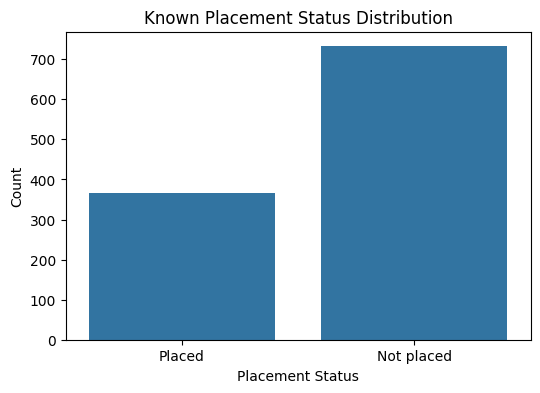

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x="Placement Status")
plt.title("Known Placement Status Distribution")
plt.xlabel("Placement Status")
plt.ylabel("Count")
plt.show()

## 🧠 Step 3: Feature Selection & Exploratory Analysis

We will use the following features:
- CGPA  
- Speaking Skills  
- ML Knowledge  

Now we analyze distributions and relationship with placement status.


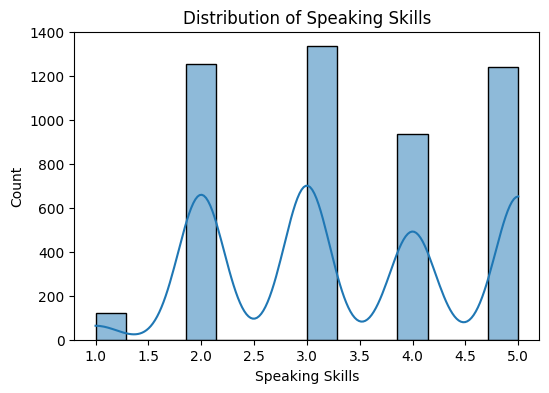

In [6]:
features = ["CGPA", "Speaking Skills", "ML Knowledge"]

plt.figure(figsize=(6,4))
sns.histplot(train_df["Speaking Skills"], kde=True)
plt.title("Distribution of Speaking Skills")
plt.show()

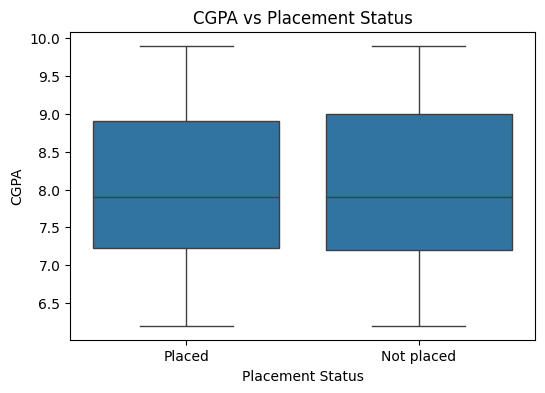

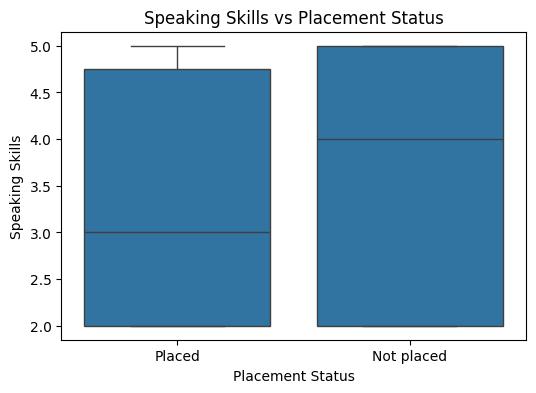

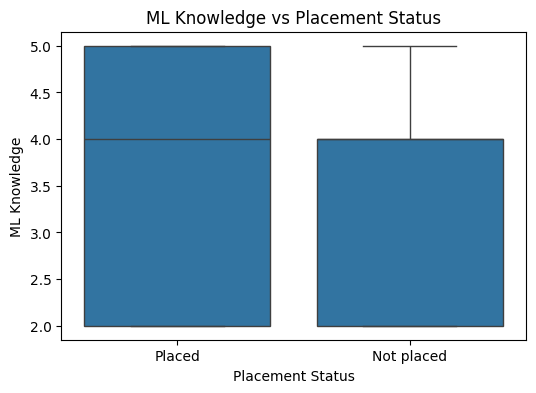

In [8]:
plt.figure(figsize=(6,4))
sns.boxplot(data=train_df, x="Placement Status", y="CGPA")
plt.title("CGPA vs Placement Status")
plt.show()
print()

plt.figure(figsize=(6,4))
sns.boxplot(data=train_df, x="Placement Status", y="Speaking Skills")
plt.title("Speaking Skills vs Placement Status")
plt.show()
print()

plt.figure(figsize=(6,4))
sns.boxplot(data=train_df, x="Placement Status", y="ML Knowledge")
plt.title("ML Knowledge vs Placement Status")
plt.show()

## 🏷️ Step 4: Encode Placement Status into Binary

We convert:
- `Placed` → 1  
- `Not placed` → 0  

Then split:
- **Known labeled rows**
- **Unknown unlabeled rows**


In [9]:
df = train_df.copy()

# Encode target
df["Placement_binary"] = np.nan
df.loc[df["Placement Status"] == "Placed", "Placement_binary"] = 1
df.loc[df["Placement Status"] == "Not placed", "Placement_binary"] = 0

# Split into labeled + unlabeled
known_df   = df.dropna(subset=["Placement_binary"])
unknown_df = df[df["Placement_binary"].isna()]

print("Known labeled rows :", known_df.shape)
print("Unknown label rows :", unknown_df.shape)

known_df.head()

Known labeled rows : (1098, 24)
Unknown label rows : (3796, 24)


,First Name,Email ID,Quantity,Price Tier,Ticket Type,Attendee #,Group,Order Type,Currency,Total Paid,...,College Name,How did you come to know about this event?,"Specify in ""Others"" (how did you come to know about this event)",Designation,Year of Graduation,CGPA,Speaking Skills,ML Knowledge,Placement Status,Placement_binary
0,ANIKET,aniket@xyz.com,1,NaN,Art of Resume Building,2.213855e+09,NaN,Free Order,USD,0,...,D Y PATIL INSTITUTE OF MCA AND MANAGEMENT AKUR...,Email,NaN,Students,NaN,6.7,2,5,Placed,1.0
1,Dhanshree,dhanshree@xyz.com,1,NaN,Art of Resume Building,2.213859e+09,NaN,Free Order,USD,0,...,AP SHAH INSTITUTE OF TECHNOLOGY,Others,College,Students,NaN,8.2,3,2,Not placed,0.0
2,Dhiraj,dhiraj@xyz.com,1,NaN,Art of Resume Building,2.213862e+09,NaN,Free Order,USD,0,...,Don Bosco College of Engineering Fatorda Goa,Email,NaN,Students,NaN,6.5,4,3,Not placed,0.0
3,Pooja,pooja@xyz.com,1,NaN,Art of Resume Building,2.213988e+09,NaN,Free Order,USD,0,...,Pillai College of Engineering New Panvel,Email,NaN,Students,NaN,8.7,2,5,Not placed,0.0
4,Aayush,aayush@xyz.com,1,NaN,Art of Resume Building,2.214567e+09,NaN,Free Order,USD,0,...,St Xavier's College,Instagram | LinkedIn | Cloud Counselage Website,NaN,Students,NaN,9.1,3,5,Placed,1.0


## 🧩 Step 5: Fill Missing Placement Labels (Semi-Supervised Step)

To avoid dropping rows, we train a temporary XGBoost model on known labels  
and predict missing `Placement Status`.


In [10]:
X_known = known_df[features]
y_known = known_df["Placement_binary"]

# Scaling improves XGBoost stability
scaler = StandardScaler()
X_known_scaled = scaler.fit_transform(X_known)

# Helper model to fill missing labels
xgb_fill = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb_fill.fit(X_known_scaled, y_known)

# Predict missing labels
X_unknown_scaled = scaler.transform(unknown_df[features])
unknown_preds = xgb_fill.predict(X_unknown_scaled)

# Fill them back into the dataframe
df.loc[df["Placement_binary"].isna(), "Placement_binary"] = unknown_preds
df["Placement_binary"] = df["Placement_binary"].astype(int)

print("All labels filled. Final dataset size:", df.shape)

All labels filled. Final dataset size: (4894, 24)


## ✅ Step 6: Prepare Final Dataset

Now we create the final dataset with only:
- CGPA  
- Speaking Skills  
- ML Knowledge  
- Placement (0/1)


In [11]:
final_df = df[features + ["Placement_binary"]].copy()
final_df.rename(columns={"Placement_binary": "Placement"}, inplace=True)

final_df.head()

,CGPA,Speaking Skills,ML Knowledge,Placement
0,6.7,2,5,1
1,8.2,3,2,0
2,6.5,4,3,0
3,8.7,2,5,0
4,9.1,3,5,1


## ⚙️ Step 7: Train-Test Split + Scaling + SMOTE

- We split the data into train/test
- Scale features
- Apply SMOTE to balance classes


In [12]:
X = final_df[features]
y = final_df["Placement"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

# Scaling
scaler_final = StandardScaler()
X_train = scaler_final.fit_transform(X_train)
X_test  = scaler_final.transform(X_test)

# SMOTE for class balancing
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE :", pd.Series(y_train_res).value_counts().to_dict())

Before SMOTE: {0: 3048, 1: 622}
After SMOTE : {0: 3048, 1: 3048}


## 🚀 Step 8: Train Final XGBoost Model

This is the final model used for evaluation and prediction.


In [13]:
baseline_xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

baseline_xgb.fit(X_train_res, y_train_res)
print("Model training completed.")

Model training completed.


## 📌 Step 9: Model Evaluation

We evaluate using:
- Accuracy
- Precision
- Recall
- F1 Score

Also we visualize a confusion matrix.


In [14]:
baseline_preds = baseline_xgb.predict(X_test)

print("Baseline Performance (Threshold = 0.5)\n")
print("Accuracy :", accuracy_score(y_test, baseline_preds))
print("Precision:", precision_score(y_test, baseline_preds))
print("Recall   :", recall_score(y_test, baseline_preds))
print("F1 Score :", f1_score(y_test, baseline_preds))

Baseline Performance (Threshold = 0.5)

Accuracy : 0.9142156862745098
Precision: 0.8198757763975155
Recall   : 0.6346153846153846
F1 Score : 0.7154471544715447


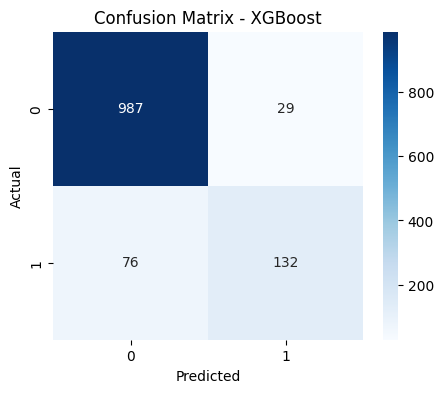

In [15]:
cm = confusion_matrix(y_test, baseline_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

## 📤 Step 10: Predict on Test Dataset & Export

We now apply the same preprocessing and predict placement for test dataset.  
Finally we export the output into an Excel file.


In [18]:
# Fill missing feature values in test set using training median
test_df[features] = test_df[features].fillna(final_df[features].median())

# Apply scaling
test_scaled = scaler_final.transform(test_df[features])

# Predict
test_preds = baseline_xgb.predict(test_scaled)

# Create output file
output = test_df.copy()
output["Predicted Placement Status"] = pd.Series(test_preds).map({1: "Placed", 0: "Not placed"})

output.to_excel("baseline_placement_predictions.xlsx", index=False)

print("Exported: baseline_placement_predictions.xlsx")
output.head()

✅ Exported: baseline_placement_predictions.xlsx


,First Name,Email ID,Quantity,Price Tier,Ticket Type,Attendee #,Group,Order Type,Currency,Total Paid,...,College Name,How did you come to know about this event?,"Specify in ""Others"" (how did you come to know about this event)",Designation,Year of Graduation,CGPA,Speaking Skills,ML Knowledge,Placement Status,Predicted Placement Status
0,Sahil,sahil@xyz.com,1,NaN,Hello ML and DL,2.293940e+09,NaN,Free Order,USD,0,...,"symbiosis institute of technology, pune",Whatsapp,NaN,Students,NaN,7.8,3,3,NaN,Not placed
1,Amrita,amrita@xyz.com,1,NaN,Hello ML and DL,2.293941e+09,NaN,Free Order,USD,0,...,"mit academy of engineering ,alandi",Whatsapp,NaN,Students,NaN,9.1,3,3,NaN,Placed
2,Mamta,mamta@xyz.com,1,NaN,Hello ML and DL,2.293941e+09,NaN,Free Order,USD,0,...,a. c. patil college of engineering,Whatsapp,NaN,Students,NaN,6.9,2,2,NaN,Not placed
3,Bhagyashri,bhagyashri@xyz.com,1,NaN,Hello ML and DL,2.293946e+09,NaN,Free Order,USD,0,...,wilson college,Others,NaN,Students,NaN,8.4,4,4,NaN,Not placed
4,Divyanshu,divyanshu@xyz.com,1,NaN,Hello ML and DL,2.293956e+09,NaN,Free Order,USD,0,...,"ld college of engineering, ahmedabad, gujarat",Whatsapp,NaN,Students,NaN,6.7,5,5,NaN,Not placed


# ✅ Conclusion

- The model successfully predicts student placement status.
- XGBoost performed best with balanced training using SMOTE.
- Predictions were generated for the test dataset and exported to Excel.

📌 Next improvements:
- Hyperparameter tuning using GridSearchCV  
- Add more features (Internships, Projects, Aptitude Score etc.)
- Try threshold tuning for higher recall